In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import h5py
import os
import simba as si
import shutil
import warnings
warnings.filterwarnings('ignore')

In [2]:
#shutil.rmtree('result_simba_rnaseq')

In [3]:
workdir = 'result_simba_rnaseq'
si.settings.set_workdir(workdir)
si.settings.set_figure_params(dpi=80,
                              style='white',
                              fig_size=[5,5],
                              rc={'image.cmap': 'viridis'})

Saving results in: result_simba_rnaseq


In [4]:
dataset = ['Trachea','fetal_liver_atlas']

In [5]:
##Trachea
data = dataset[0]
dir0 = '../'

In [6]:
with h5py.File(os.path.join(dir0, 'datasets/co-expression/{}/{}.h5').format(data, data)) as data_mat:
    X = np.array(data_mat['X'])
    X = np.ceil(X).astype(np.float)
adata = sc.AnnData(X)
gene = pd.read_csv(os.path.join(dir0, 'datasets/co-expression/{}/{}_geneset.csv').format(data, data),
                   header=0).values.squeeze()
adata.var['feature_types'] = gene
celltype = pd.read_csv(os.path.join(dir0, 'datasets/co-expression/{}/{}_celltype.csv').format(data, data), header=None).values
celltype = np.array(celltype).squeeze()
adata.var_names = gene
adata.obs['Cell Type'] = celltype
print("number of cell type: {}".format(len(np.unique(adata.obs['Cell Type']))))
print(adata)

number of cell type: 7
AnnData object with n_obs × n_vars = 7193 × 18388
    obs: 'Cell Type'
    var: 'feature_types'


In [7]:
## fetal_liver_atlas
data = dataset[1]
dir0 = '../'

In [8]:
adata0 = sc.read_h5ad(os.path.join(dir0, 'datasets/co-expression/{}/sample_fetal_liver_atlas_dataset.h5ad').format(data))
count = np.array(adata0.raw.X.todense())
adata = sc.AnnData(count)
adata.var_names = adata0.raw.var_names
adata.obs['Cell Type'] = np.array(adata0.obs['Cell.Labels'].values)
print("number of cell type:{}".format(len(np.unique(adata.obs['Cell Type']))))
adata.var['feature_types'] = adata.var_names
print(adata)

number of cell type:7
AnnData object with n_obs × n_vars = 500 × 28790
    obs: 'Cell Type'
    var: 'feature_types'


In [9]:
si.pp.filter_genes(adata,min_n_cells=3)
si.pp.filter_cells_rna(adata,min_n_genes=100)

si.pp.normalize(adata,method='lib_size')
si.pp.log_transform(adata)
si.pp.select_variable_genes(adata, n_top_genes=1000)

print(adata)

Before filtering: 
500 cells, 28790 genes
Filter genes based on min_n_cells
After filtering out low-expressed genes: 
500 cells, 14981 genes
before filtering: 
500 cells,  14981 genes
filter cells based on min_n_genes
after filtering out low-quality cells: 
500 cells,  14981 genes
1000 variable genes are selected.
AnnData object with n_obs × n_vars = 500 × 14981
    obs: 'Cell Type', 'n_counts', 'n_genes', 'pct_genes'
    var: 'feature_types', 'n_counts', 'n_cells', 'pct_cells', 'variances_norm', 'variances', 'means', 'highly_variable'
    layers: 'raw'


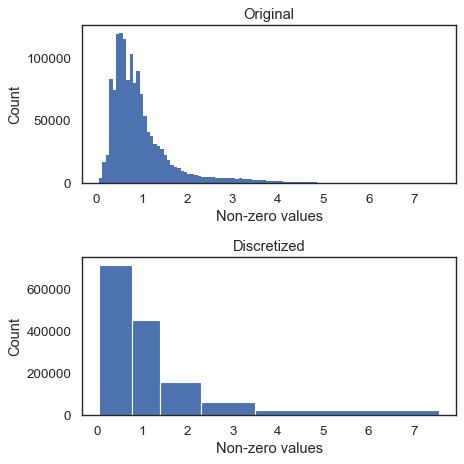

In [10]:
si.tl.discretize(adata,n_bins=5)
si.pl.discretize(adata,kde=False)

In [11]:
si.tl.gen_graph(list_CG=[adata],
                use_highly_variable=True,
                dirname='graph0')

relation0: source: C, destination: G
#edges: 35673
relation1: source: C, destination: G
#edges: 25058
relation2: source: C, destination: G
#edges: 14247
relation3: source: C, destination: G
#edges: 5847
relation4: source: C, destination: G
#edges: 2023
Total number of edges: 82848
Writing graph file "pbg_graph.txt" to "result_simba_rnaseq\pbg\graph0" ...
Finished.


In [12]:
dict_config = si.settings.pbg_params.copy()
# dict_config['wd'] = 0.015521
# dict_config['wd_interval'] = 10 # we usually set `wd_interval` to 10 for scRNA-seq datasets for a slower but finer training
dict_config['workers'] = 16 #The number of CPUs.
dict_config['num_epochs'] = 10
dict_config['dimension'] = 64

In [13]:
si.tl.pbg_train(pbg_params=dict_config, auto_wd=True, save_wd=True, output='model')

Auto-estimated weight decay is 0.427713
`.settings.pbg_params['wd']` has been updated to 0.427713
Converting input data ...
[2023-08-27 17:10:25.239739] Using the 5 relation types given in the config
[2023-08-27 17:10:25.239739] Searching for the entities in the edge files...
[2023-08-27 17:10:25.343454] Entity type C:
[2023-08-27 17:10:25.344455] - Found 500 entities
[2023-08-27 17:10:25.344455] - Removing the ones with fewer than 1 occurrences...
[2023-08-27 17:10:25.344455] - Left with 500 entities
[2023-08-27 17:10:25.344455] - Shuffling them...
[2023-08-27 17:10:25.345455] Entity type G:
[2023-08-27 17:10:25.345455] - Found 1000 entities
[2023-08-27 17:10:25.346455] - Removing the ones with fewer than 1 occurrences...
[2023-08-27 17:10:25.346455] - Left with 1000 entities
[2023-08-27 17:10:25.346455] - Shuffling them...
[2023-08-27 17:10:25.347455] Preparing counts and dictionaries for entities and relation types:
[2023-08-27 17:10:25.348456] - Writing count of entity type C and p

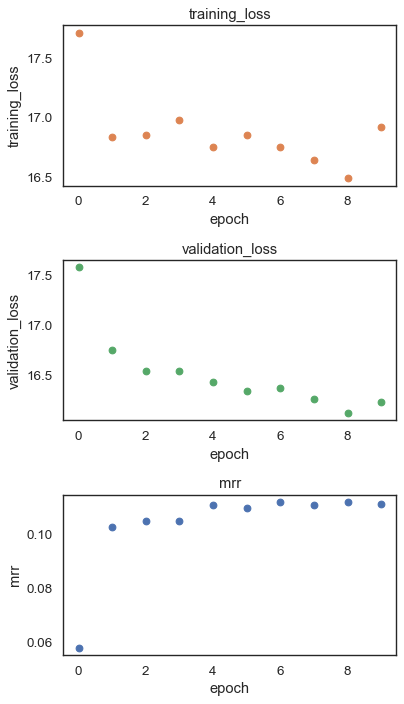

In [14]:
si.pl.pbg_metrics(fig_ncol=1)

In [15]:
dict_adata = si.read_embedding()
dict_adata

{'C': AnnData object with n_obs × n_vars = 500 × 64,
 'G': AnnData object with n_obs × n_vars = 1000 × 64}

In [16]:
adata_C = dict_adata['C']  # embeddings of cells
adata_G = dict_adata['G']  # embeddings of genes

In [17]:
adata_G.obs_names

Index(['TSTD1', 'MZB1', 'ASPG', 'BCL2A1', 'KB-208E9.1', 'FTCD', 'RASGEF1B',
       'SERPINA11', 'H2AFZ', 'HSD17B12',
       ...
       'TUBA1A', 'SNHG25', 'TCEA3', 'RGS16', 'CYP4F3', 'HLA-DQB1', 'IGSF1',
       'FAM178B', 'VPREB3', 'PCOLCE'],
      dtype='object', length=1000)

In [18]:
np.savez(os.path.join(dir0,"results/co-expression/{}_simba.npz".format(data)),
         data = adata.X,
         E_feature = adata_G.X,
         cell_type = adata.obs['Cell Type'],
         gene_name = adata_G.obs_names)